# Objective: Does higher GDP and income per capita necessarily dictate higher waste?

## Setup

In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scikit_posthocs as sp

## Read data

In [2]:
path_to_dataset = r'C:\\Users\\patil\\Documents\\GitHub\\trashmap\\data\\processed'
filename = '01a_country_level_data.csv'
full_file_path = os.path.join(path_to_dataset, filename)
df = pd.read_csv(full_file_path)

In [3]:
df

,country,income,gdp,population,total_msw,msw_per_cap
0,Aruba,HIC,35563.312500,103187.0,8.813202e+04,774.826708
1,Afghanistan,LIC,2057.062256,34656032.0,5.628525e+06,147.336942
2,Angola,LMC,8036.690430,25096150.0,4.213644e+06,152.316361
3,Albania,UMC,13724.058590,2854191.0,1.087447e+06,345.637478
4,Andorra,HIC,43711.800780,82431.0,4.300000e+04,473.231612
...,...,...,...,...,...,...
209,Kosovo,LMC,9723.561523,1801800.0,3.190000e+05,160.612729
210,"Yemen, Rep.",LIC,8269.671875,27584212.0,4.836820e+06,159.072536
211,South Africa,UMC,12666.607420,51729344.0,1.845723e+07,323.687152
212,Zambia,LMC,3201.289307,14264756.0,2.608268e+06,165.876066


## Check for assumptions of ANOVA:
Independent var (income levels) is categorical, dependent (MSW per capita) is metric and continuous
Measurements are independent
Are the samples normally distributed and have roughly equal variance?

In [38]:
filename = '02a_msw_per_cap_by_income_kdeplot.jpeg'
full_file_path = os.path.join(path_to_dataset, filename)

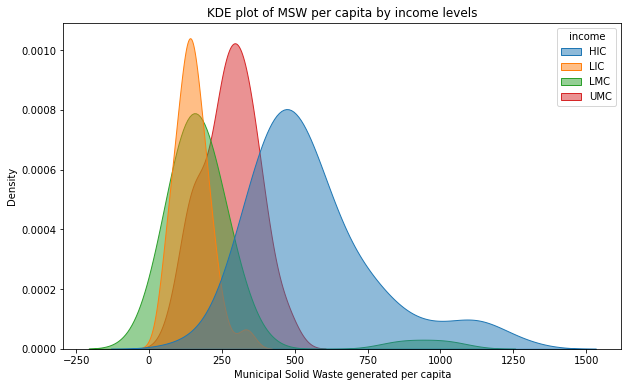

In [39]:
plt.figure(figsize=(10,6))
sns.kdeplot(data = df, x = 'msw_per_cap', hue = 'income', fill = True, alpha = 0.5)
plt.title(f'KDE plot of MSW per capita by income levels')
plt.xlabel('Municipal Solid Waste generated per capita')
plt.savefig(full_file_path)

On the outset, data looks normally distributed but definitely not euqal variance. Checking with statistical test

### Test for normality

In [26]:
inc_level = list(df['income'].unique())
alpha = 0.5

In [27]:
for inc in inc_level:
    group = df[df['income'] == inc]['msw_per_cap']
    shapiro_statistic, p_value = stats.shapiro(group)
    if p_value < alpha:
        print(f"p-value {round(p_value,2)} Reject hypothesis: Non-normal distribution for income level {inc}")
    else:
        print (f"p-value {round(p_value,2)} Fail to reject hypothesis: Normal distribution for income level {inc}")

p-value 0.0 Reject hypothesis: Non-normal distribution for income level HIC
p-value 0.1 Reject hypothesis: Non-normal distribution for income level LIC
p-value 0.0 Reject hypothesis: Non-normal distribution for income level LMC
p-value 0.57 Fail to reject hypothesis: Normal distribution for income level UMC


### Test for equal variance

In [28]:
df.groupby('income')['msw_per_cap'].std()

income
HIC    220.938585
LIC     58.870548
LMC    173.475347
UMC     93.533304
Name: msw_per_cap, dtype: float64

In [29]:
groups = [df[df['income'] == inc]['msw_per_cap'].values for inc in inc_level]
levene_statistic, p_value = stats.levene(*groups, center='median')
if p_value < alpha:
    print(f"p-value {round(p_value,2)} Reject hypothesis: Unequal variances")
else:
    print (f"p-value {round(p_value,2)} Fail to reject hypothesis: Equal variances")

p-value 0.0 Reject hypothesis: Unequal variances


## Trying non-parametric test (Kruskal Wallis test)
Test for statistical significance in distribution of multiple groups

In [30]:
df.groupby('income')['msw_per_cap'].count()

income
HIC    78
LIC    33
LMC    47
UMC    56
Name: msw_per_cap, dtype: int64

In [32]:
H_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis H Statistic: {H_statistic:.3f}")
print(f"P-value: {p_value:.5f}")

Kruskal-Wallis H Statistic: 141.635
P-value: 0.00000


### Conclusion: At least one of the groups is significantly different from the rest. Follow up with post hoc test.

## Using Dunn's test with Holm's correction (non parametric counterpart to Benferroni test)

In [37]:
posthoc_results = sp.posthoc_dunn(
    a=df,
    val_col='msw_per_cap',
    group_col='income',
    p_adjust='holm' # Holm correction is a powerful alternative to Bonferroni
)

print(posthoc_results)

              HIC           LIC           LMC           UMC
HIC  1.000000e+00  1.682918e-21  2.127284e-21  1.000949e-09
LIC  1.682918e-21  1.000000e+00  3.086593e-01  1.059362e-04
LMC  2.127284e-21  3.086593e-01  1.000000e+00  1.253748e-03
UMC  1.000949e-09  1.059362e-04  1.253748e-03  1.000000e+00


### Conclusion: 
#### HIC and UMC are statistically different from all other groups, while LIC and LMC are the only 2 similar to each other (shown by overlapped curve). As countries develop from Low Income (<1k) to Lower Middle income (1k to 4k), waste generation per capita remains similar, however as countries progress further, waste generation gets significantly higher.